In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
nltk=3.4.5 already installed
unidecode=1.0.23 already installed
pydotplus=2.0.2 already installed


<h1>Desafio 3 - Grupo 5</h1>

<h3><u>Intregrantes del grupo</u></h3>

- Juan Pablo Ferrari
- Alejandro Jait
- Miriam Lanabere
- Panizza, Camila    

<h3><u>Objetivos</u></h3>
A partir del dataset seleccionado: "Información del Mapa de Oportunidades Comerciales"
nuestro objetivo será determinar cuál es el nivel de riesgo para emprendedores y comerciantes 
a la hora de abrir o potenciar un comercio en la Ciudad Autónoma de Buenos Aires.
Para esto, contaremos con variables como: rubro, zona, información demográfica y facturación.


<h3><u>Índice</u></h3>
<a href='#section_1'>1. Preparación del dataset</a> 

<a href='#section_2'>2. Dataset final</a>  
<a href='#section_3'>3. Modelos implementados</a>  
<a href='#section_4'>4. Modelos + reducción de dimensionalidad</a>  
<a href='#section_5'>5. Modelos + Grid search</a> 

---
---
<b><a id='section_1'><h4>1. Preparación del dataset</h4></a></b>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [4]:
df_zonas = pd.read_csv('Data/zonas.csv', sep=';')
df_comercios = pd.read_csv('Data/COMERCIOS.csv', sep=',')

In [5]:
df_zonas.rename(columns={'MOC_ZONAS_ID':'ID_ZONA'}, inplace=True)

In [6]:
df = df_comercios.join(df_zonas, how='left', on='ID_ZONA', lsuffix='', rsuffix='_df2')

In [7]:
df.drop(columns=['ID_ZONA_df2', 'PK_TIEMPO_ID', 'FECHA', 'PERIODO'], axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26082 entries, 0 to 26081
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_ZONA                                    26082 non-null  int64  
 1   RUBRO                                      26082 non-null  object 
 2   NIVEL_RIESGO                               26082 non-null  int64  
 3   APERTURAS                                  26082 non-null  float64
 4   CIERRES                                    26082 non-null  float64
 5   SUPERVIVENCIA                              21473 non-null  float64
 6   PROMEDIO_VENTAS                            26082 non-null  int64  
 7   CANTIDAD_LOCALES                           26082 non-null  int64  
 8   SUPERV_MENOS_1                             26082 non-null  float64
 9   SUPERV_ENTRE_1_Y_2                         26082 non-null  float64
 10  SUPERV_ENTRE_2_Y_3    

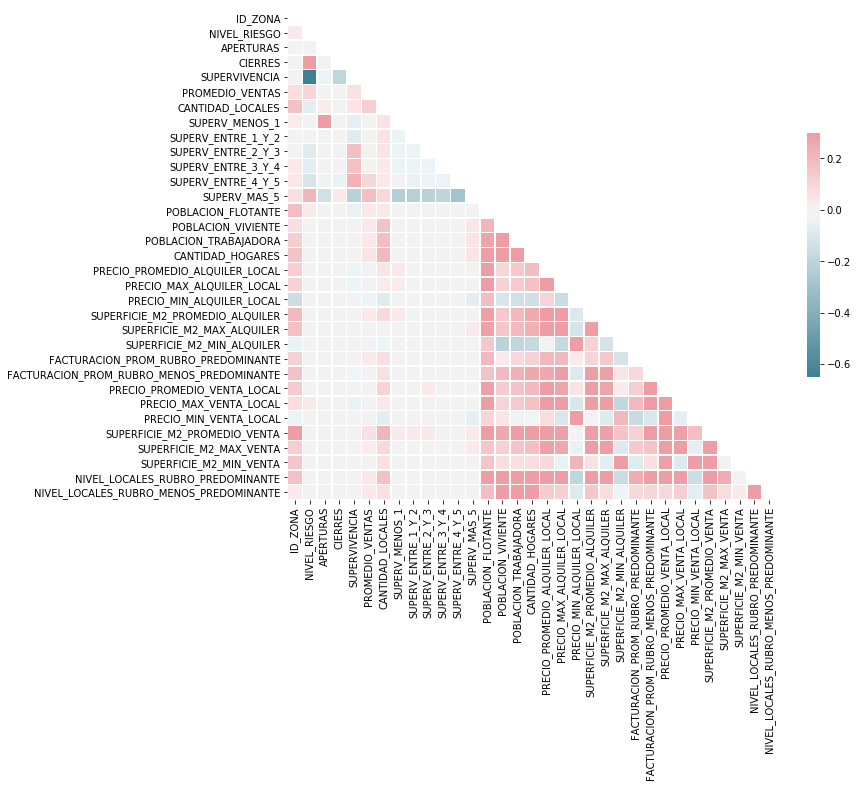

In [9]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

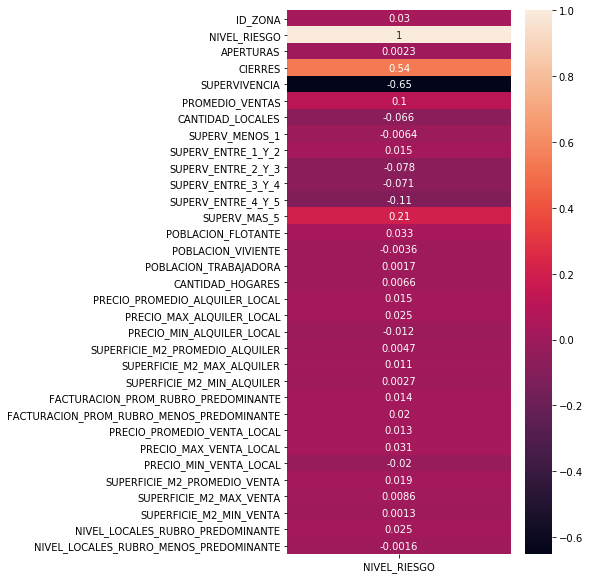

In [10]:
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['NIVEL_RIESGO']], annot=True)

In [11]:
df.drop(columns=['SUPERVIVENCIA'], axis=1, inplace=True)

In [12]:
df.columns.values

array(['ID_ZONA', 'RUBRO', 'NIVEL_RIESGO', 'APERTURAS', 'CIERRES',
       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES', 'SUPERV_MENOS_1',
       'SUPERV_ENTRE_1_Y_2', 'SUPERV_ENTRE_2_Y_3', 'SUPERV_ENTRE_3_Y_4',
       'SUPERV_ENTRE_4_Y_5', 'SUPERV_MAS_5', 'POBLACION_FLOTANTE',
       'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA', 'CANTIDAD_HOGARES',
       'PRECIO_PROMEDIO_ALQUILER_LOCAL', 'PRECIO_MAX_ALQUILER_LOCAL',
       'PRECIO_MIN_ALQUILER_LOCAL', 'SUPERFICIE_M2_PROMEDIO_ALQUILER',
       'SUPERFICIE_M2_MAX_ALQUILER', 'SUPERFICIE_M2_MIN_ALQUILER',
       'RUBRO_PREDOMINANTE', 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
       'RUBRO_MENOS_PREDOMINANTE', 'PRECIO_PROMEDIO_VENTA_LOCAL',
       'PRECIO_MAX_VENTA_LOCAL', 'PRECIO_MIN_VENTA_LOCAL',
       'SUPERFICIE_M2_PROMEDIO_VENTA', 'SUPERFICIE_M2_MAX_VENTA',
       'SUPERFICIE_M2_MIN_VENTA', 'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE'], dtype=object)

In [13]:
df['ID_ZONA'] = df['ID_ZONA'].astype(str)

In [14]:
df.dropna(inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24300 entries, 18 to 26063
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_ZONA                                    24300 non-null  object 
 1   RUBRO                                      24300 non-null  object 
 2   NIVEL_RIESGO                               24300 non-null  int64  
 3   APERTURAS                                  24300 non-null  float64
 4   CIERRES                                    24300 non-null  float64
 5   PROMEDIO_VENTAS                            24300 non-null  int64  
 6   CANTIDAD_LOCALES                           24300 non-null  int64  
 7   SUPERV_MENOS_1                             24300 non-null  float64
 8   SUPERV_ENTRE_1_Y_2                         24300 non-null  float64
 9   SUPERV_ENTRE_2_Y_3                         24300 non-null  float64
 10  SUPERV_ENTRE_3_Y_4   

In [16]:
df['NIVEL_RIESGO'].value_counts()

1    10453
2     7967
3     4142
4     1482
5      256
Name: NIVEL_RIESGO, dtype: int64

In [17]:
df.loc[(df.NIVEL_RIESGO == 4) | (df.NIVEL_RIESGO == 5), 'NIVEL_RIESGO'] = 3

In [18]:
df['NIVEL_RIESGO'].value_counts()

1    10453
2     7967
3     5880
Name: NIVEL_RIESGO, dtype: int64

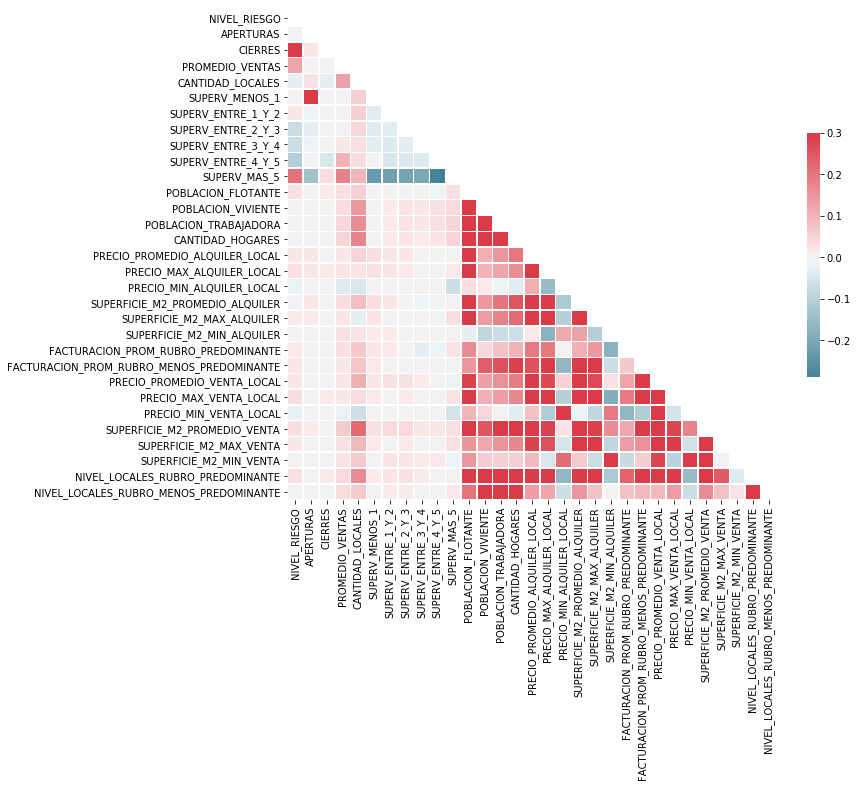

In [19]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

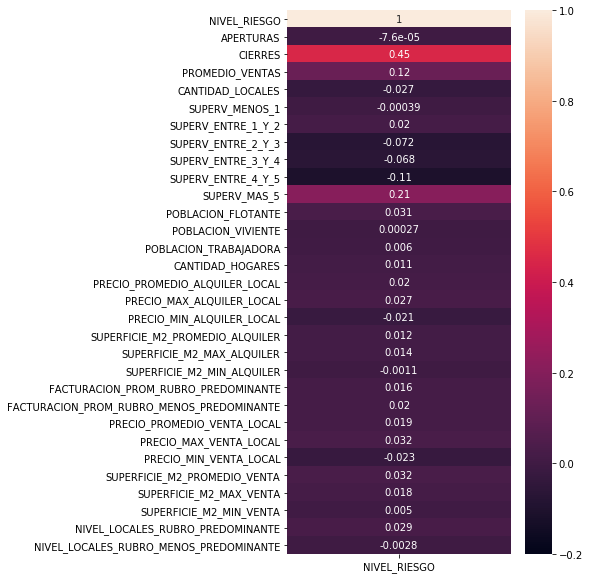

In [20]:
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['NIVEL_RIESGO']], annot=True, vmin=-0.2)

In [21]:
df['NR_STR'] = df['NIVEL_RIESGO'].astype(str)

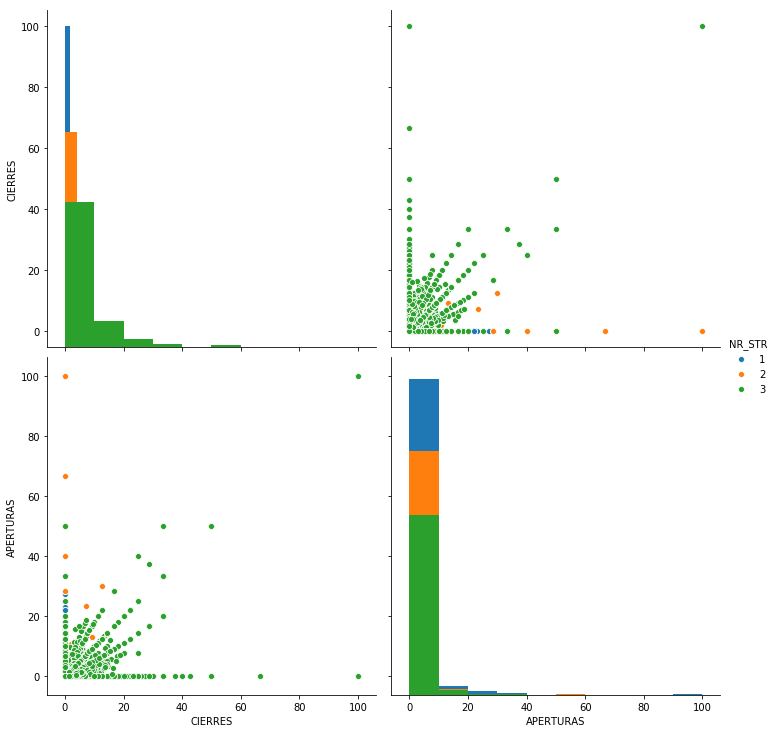

In [22]:
sns.pairplot(data=df[['CIERRES', 'APERTURAS', 'NR_STR']], vars=['CIERRES', 'APERTURAS'], hue='NR_STR', height=5, diag_kind='hist');

In [25]:
df['ID_ZONA'].value_counts().unique()

array([162], dtype=int64)

In [26]:
df['RUBRO'].value_counts().unique()

array([1350], dtype=int64)

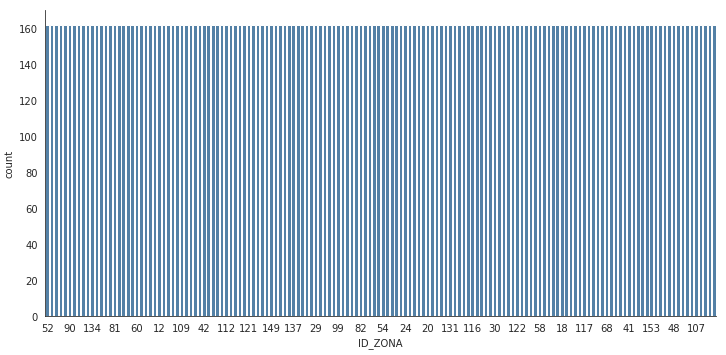

In [28]:
with sns.axes_style('white'):
    g = sns.catplot("ID_ZONA", data=df, aspect=2, kind="count", color='steelblue', order = df['ID_ZONA'].value_counts().index)
    g.set_xticklabels(step=5)

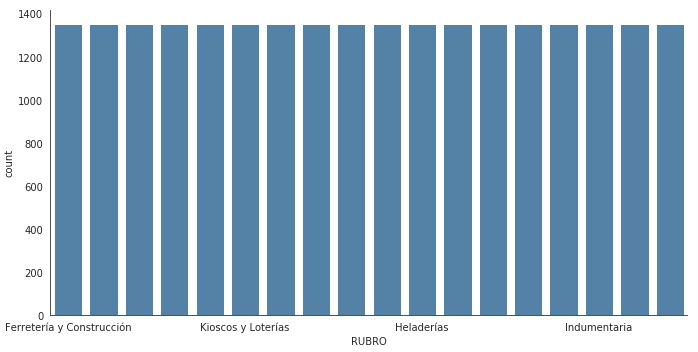

In [29]:
with sns.axes_style('white'):
    g = sns.catplot("RUBRO", data=df, aspect=2, kind="count", color='steelblue', order = df['RUBRO'].value_counts().index)
    g.set_xticklabels(step=5)

---
---
<b><a id='section_2'><h4>2. Dataset final</h4></a></b>

In [30]:
predecir = ['NIVEL_RIESGO']

# Sin Supervivencia y otras columnas relacionadas
#features = ['ID_ZONA', 'RUBRO', 'APERTURAS', 'CIERRES',
#       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES',
#       'POBLACION_FLOTANTE', 'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA',
#       'CANTIDAD_HOGARES', 'PRECIO_PROMEDIO_ALQUILER_LOCAL',
#       'PRECIO_MAX_ALQUILER_LOCAL', 'PRECIO_MIN_ALQUILER_LOCAL',
#       'SUPERFICIE_M2_PROMEDIO_ALQUILER', 'SUPERFICIE_M2_MAX_ALQUILER',
#       'SUPERFICIE_M2_MIN_ALQUILER', 'RUBRO_PREDOMINANTE',
#       'FACTURACION_PROM_RUBRO_PREDOMINANTE',
#       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE', 'RUBRO_MENOS_PREDOMINANTE',
#       'PRECIO_PROMEDIO_VENTA_LOCAL', 'PRECIO_MAX_VENTA_LOCAL',
#       'PRECIO_MIN_VENTA_LOCAL', 'SUPERFICIE_M2_PROMEDIO_VENTA',
#       'SUPERFICIE_M2_MAX_VENTA', 'SUPERFICIE_M2_MIN_VENTA',
#       'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
#       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE']

features = ['ID_ZONA', 'RUBRO', 'APERTURAS', 'CIERRES',
       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES', 'SUPERV_MENOS_1',
       'SUPERV_ENTRE_1_Y_2', 'SUPERV_ENTRE_2_Y_3', 'SUPERV_ENTRE_3_Y_4',
       'SUPERV_ENTRE_4_Y_5', 'SUPERV_MAS_5', 'POBLACION_FLOTANTE',
       'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA', 'CANTIDAD_HOGARES',
       'PRECIO_PROMEDIO_ALQUILER_LOCAL', 'PRECIO_MAX_ALQUILER_LOCAL',
       'PRECIO_MIN_ALQUILER_LOCAL', 'SUPERFICIE_M2_PROMEDIO_ALQUILER',
       'SUPERFICIE_M2_MAX_ALQUILER', 'SUPERFICIE_M2_MIN_ALQUILER',
       'RUBRO_PREDOMINANTE', 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
       'RUBRO_MENOS_PREDOMINANTE', 'PRECIO_PROMEDIO_VENTA_LOCAL',
       'PRECIO_MAX_VENTA_LOCAL', 'PRECIO_MIN_VENTA_LOCAL',
       'SUPERFICIE_M2_PROMEDIO_VENTA', 'SUPERFICIE_M2_MAX_VENTA',
       'SUPERFICIE_M2_MIN_VENTA', 'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE']

In [32]:
# Creamos dummies
df_final = pd.get_dummies(df[features], columns=['ID_ZONA', 
                                                 'RUBRO', 
                                                 'RUBRO_PREDOMINANTE', 
                                                 'RUBRO_MENOS_PREDOMINANTE',
                                                 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
                                                 'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
                                                 'NIVEL_LOCALES_RUBRO_PREDOMINANTE', 
                                                 'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE'], drop_first=True)

In [33]:
X = df_final
y = df[predecir]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [36]:
X_train.shape

(18225, 224)

In [37]:
y_train.shape

(18225, 1)

---
---
<b><a id='section_3'><h4>3. Modelos implementados</h4></a></b>
<a href='#section_3_1'>3.1. Regresión logística</a>  
<a href='#section_3_2'>3.2. KNeighborsClassifier</a>  

<b><a id='section_3_1'>3.1. Regresión logística</a>  </b>

In [38]:
logistic_regression = LogisticRegression(solver='newton-cg')

In [39]:
logistic_regression.fit(X_train_std, y_train.values.reshape(-1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred_test = logistic_regression.predict(X_test_std)

In [41]:
accuracy_score(y_test, y_pred_test)

0.711275720164609

In [42]:
y_test['NIVEL_RIESGO'].value_counts()

1    2613
2    1992
3    1470
Name: NIVEL_RIESGO, dtype: int64

Text(33,0.5,'Reales')

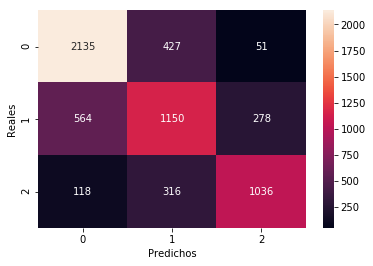

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [44]:
y_pred_proba_logit = logistic_regression.predict_proba(X_test_std)

In [45]:
y_pred_proba_logit.shape

(6075, 3)

In [ ]:
# from sklearn.preprocessing import binarize
# y_pred_logit = binarize(y_pred_proba_logit, 0.3)[:,1]

In [ ]:
# y_probs_logit_left = y_pred_proba_logit[:,1]
# y_pred_logit = y_probs_logit_left > 0.3

In [ ]:
# sns.heatmap(confusion_matrix(y_test, y_pred_logit, ), annot=True, fmt='.0f')
# plt.xlabel('Predichos')
# plt.ylabel('Reales')

<b><a id='section_3_2'>3.2. KNeighborsClassifier</a>  </b>

In [46]:
def scores_knn(X, y, start, stop, step):
    
    # Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto vamos a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    
    # Lista de diccionarios - la inicializamos vacío y por fuera del for loop para ir alimentándola en cada iteración
    scores_para_df = []
    
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits=3, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    # Retornamos el DF
    return df_scores

In [47]:
df_scores_1= scores_knn(X_train_std, y_train.values.reshape(-1), 2, 10, 1)

In [48]:
df_scores_1

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.623868,0.006468,2,0.617400,0.630336
1,0.607188,0.005251,3,0.601937,0.612439
2,0.592044,0.009685,4,0.582359,0.601729
3,0.574760,0.009926,5,0.564834,0.584686
4,0.552099,0.004773,6,0.547326,0.556871
5,0.542003,0.006483,7,0.535520,0.548485
6,0.526475,0.006367,8,0.520107,0.532842
7,0.523621,0.003877,9,0.519745,0.527498


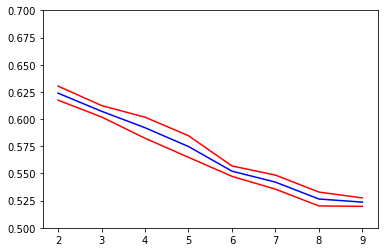

In [49]:
plt.plot(df_scores_1['n_neighbours'], df_scores_1['limite_inferior'], color='r')
plt.plot(df_scores_1['n_neighbours'], df_scores_1['score_medio'], color='b')
plt.plot(df_scores_1['n_neighbours'], df_scores_1['limite_superior'], color='r')
plt.ylim(0.5, 0.7);

In [50]:
df_scores_1.loc[df_scores_1.score_medio == df_scores_1.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.623868,0.006468,2,0.6174,0.630336


In [51]:
best_k_1 = df_scores_1.loc[df_scores_1.score_medio == df_scores_1.score_medio.max(),'n_neighbours'].values[0]
best_k_1

2

In [52]:
model_knn_1 = KNeighborsClassifier(n_neighbors=best_k_1)
model_knn_1.fit(X_train_std, y_train.values.reshape(-1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [53]:
accuracy_score(y_train, model_knn_1.predict(X_train_std))

0.8281481481481482

In [54]:
y_pred_knn_1 = model_knn_1.predict(X_test_std)

In [55]:
accuracy_score(y_test, y_pred_knn_1)

0.6483950617283951

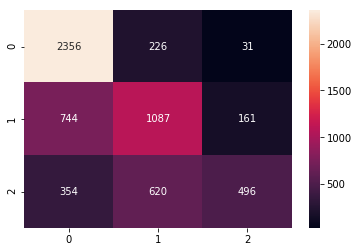

In [56]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn_1), annot=True, fmt='.0f')

---
---
<b><a id='section_4'><h4>4. Modelos + reducción de dimensionalidad</h4></a></b>
<a href='#section_4_1'>4.1. PCA + KNClassifier</a>  
<a href='#section_4_2'>4.2. PCA + NaiveBayes</a>  
<a href='#section_4_3'>4.3. PCA + Regresión Logística</a>  

<b><a id='section_4_1'>4.1. PCA + KNClassifier</a>  </b>

In [ ]:
#Veamos si mejora el score reduciendo dimensionalidad

In [57]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

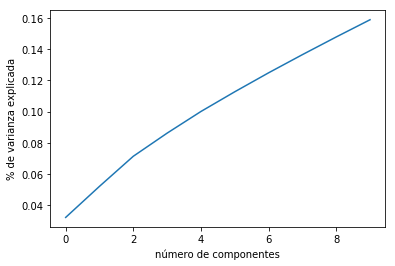

In [58]:
plot_explained_variance(components_count = 10, X = X_train_std)

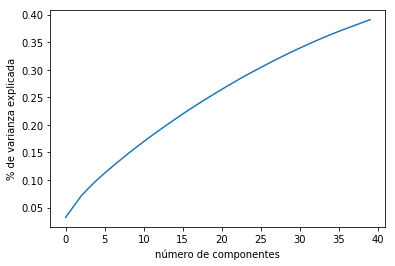

In [73]:
plot_explained_variance(components_count = 40, X = X_train_std)

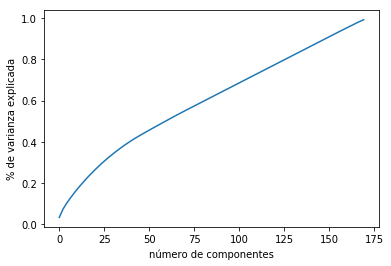

In [89]:
plot_explained_variance(components_count = 170, X = X_train_std)

In [90]:
model_pca = PCA(170).fit(X_train_std)
X_train_PCA = model_pca.transform(X_train_std)
X_test_PCA = model_pca.transform(X_test_std)

In [91]:
df_scores_2 = scores_knn(X_train_PCA, y_train.values.reshape(-1), 2, 5, 1)

In [92]:
df_scores_2

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.626173,0.008461,2,0.617712,0.634634
1,0.612346,0.007116,3,0.605230,0.619461
2,0.591660,0.011182,4,0.580477,0.602842


In [93]:
df_scores_2.loc[df_scores_2.score_medio == df_scores_2.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.626173,0.008461,2,0.617712,0.634634


In [94]:
best_k_2 = df_scores_2.loc[df_scores_2.score_medio == df_scores_2.score_medio.max(),'n_neighbours'].values[0]
best_k_2

2

In [95]:
model_knn_2 = KNeighborsClassifier(n_neighbors=best_k_2)
model_knn_2.fit(X_train_PCA, y_train.values.reshape(-1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [96]:
accuracy_score(y_train, model_knn_2.predict(X_train_PCA))

0.8330315500685871

In [97]:
y_pred_knn_2 = model_knn_2.predict(X_test_PCA)

In [98]:
accuracy_score(y_test, y_pred_knn_2)

0.6564609053497943

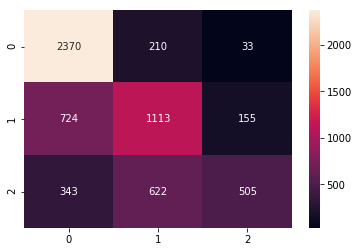

In [99]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn_2), annot=True, fmt='.0f')

<b><a id='section_4_2'>4.2. PCA + NaiveBayes</a>  </b>

In [100]:
gnb_1 = GaussianNB()
gnb_1.fit(X_train_std, y_train.values.reshape(-1))

GaussianNB(priors=None, var_smoothing=1e-09)

In [101]:
y_pred_nb_train_1 = gnb_1.predict(X_train_std)

In [102]:
accuracy_score(y_train, y_pred_nb_train_1)

0.5179698216735253

In [103]:
y_pred_nb_1 = gnb_1.predict(X_test_std)

In [104]:
accuracy_score(y_test, y_pred_nb_1)

0.49530864197530866

In [105]:
gnb_2 = GaussianNB()
gnb_2.fit(X_train_PCA, y_train.values.reshape(-1))

GaussianNB(priors=None, var_smoothing=1e-09)

In [106]:
y_pred_nb_train_2 = gnb_2.predict(X_train_PCA)

In [107]:
accuracy_score(y_train, y_pred_nb_train_2)

0.5469958847736626

In [108]:
y_pred_nb_2 = gnb_2.predict(X_test_PCA)

In [109]:
accuracy_score(y_test, y_pred_nb_2)

0.537283950617284

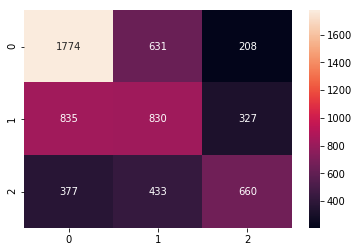

In [110]:
sns.heatmap(confusion_matrix(y_test, y_pred_nb_2), annot=True, fmt='.0f')

<b><a id='section_4_3'><h4>4.3. PCA + Regresión Logística</h4></a></b>

Best parameter (CV score=0.566):
{'logistic__C': 0.0001, 'pca__n_components': 180}


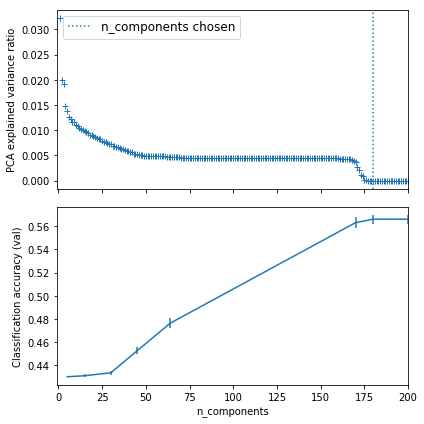

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca_2 = PCA()
# set the tolerance to a large value to make the example faster
logistic_3 = LogisticRegression(max_iter=10000, tol=0.1)
pipe_1 = Pipeline(steps=[('pca', pca_2), ('logistic', logistic_3)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_1 = {
    'pca__n_components': [5, 15, 30, 45, 64, 170, 180, 200],
    'logistic__C': np.logspace(-4, 6, 1),
}

grid_3 = GridSearchCV(pipe_1, param_grid_1, n_jobs=-1)
grid_3.fit(X_train_std, y_train.values.reshape(-1))
print("Best parameter (CV score=%0.3f):" % grid_3.best_score_)
print(grid_3.best_params_)

# Plot the PCA spectrum
pca_2.fit(X_train_std)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca_2.n_components_ + 1),
         pca_2.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(grid_3.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(grid_3.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 200)

plt.tight_layout()
plt.show()

In [125]:
y_pred_grid_3 = grid_3.predict(X_test_std)

In [126]:
accuracy_score(y_test, y_pred_grid_3)

0.5886419753086419

In [127]:
print (classification_report(y_test, y_pred_grid_3))

              precision    recall  f1-score   support

           1       0.59      0.90      0.71      2613
           2       0.49      0.38      0.43      1992
           3       0.86      0.33      0.47      1470

    accuracy                           0.59      6075
   macro avg       0.65      0.53      0.54      6075
weighted avg       0.62      0.59      0.56      6075



---
---
<b><a id='section_5'><h4>5. Modelos + Grid search</h4></a></b>

In [116]:
# penalty L1: Lasso y L2: Ridge
params_2 = [
    {'C': [1, 2, 3, 4, 5, 6, 7, 8, 10],
     'penalty': ['l1', 'l2'],
     'solver': ['newton-cg']}
]

folds_2 = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid_2 = GridSearchCV(LogisticRegression(), param_grid=params_2[0], cv=folds_2, n_jobs=2)
grid_2.fit(X_train_std, y_train.values.reshape(-1))
display(grid_2.best_estimator_, grid_2.best_score_, grid_2.best_params_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

0.6974485596707819

{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}

In [117]:
y_pred_grid_2 = grid_2.predict(X_test_std)

In [118]:
accuracy_score(y_test, y_pred_grid_2)

0.7099588477366255

In [119]:
print (classification_report(y_test, y_pred_grid_2))

              precision    recall  f1-score   support

           1       0.76      0.82      0.79      2613
           2       0.61      0.58      0.59      1992
           3       0.76      0.70      0.73      1470

    accuracy                           0.71      6075
   macro avg       0.71      0.70      0.70      6075
weighted avg       0.71      0.71      0.71      6075



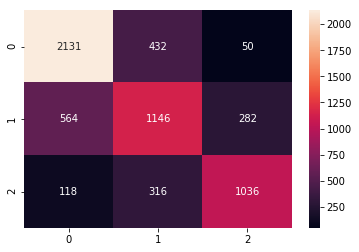

In [120]:
sns.heatmap(confusion_matrix(y_test, y_pred_grid_2), annot=True, fmt='.0f')